# Solve MoutainCar-v0 using SARSA($\lambda $) + TileCoding
This notebook solves 'MountainCar-v0' within merely 75 episodes using SARSA($\lambda $) and tile coding.

**Method**
- SARSA($\lambda $) with $\lambda = 0.9$ and replacement trace. Learning rate $\alpha = 0.03$.
- No discount $\gamma = 1$. Exploration $\epsilon = 0.001$.
- Tile coding with asymmetrical offsets. $8$ layers and $\le 2000$ features.
- No reward engineering.

**Reference**
- Ana Mohamed's solution on MountainCar-v0, which also uses SARSA($\lambda $) and tile coding: https://github.com/amohamed11/OpenAIGym-Solutions .

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

### Construct Agent

In [2]:
class TileCoder:
    def __init__(self, layers, features):
        """ 
        Parameters
        - layers: int, the number of layers in tile coding
        - features: int, the number of features, also the shape of weights
        """
        self.layers = layers
        self.features = features
        self.codebook = {}
    
    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]
        count = len(self.codebook)
        if count >= self.features: # collide when codebook is full
            return hash(codeword) % self.features
        else:
            self.codebook[codeword] = count
            return count
        
    def __call__(self, floats=(), ints=()):
        """ 
        Parameters
        - floats: tuple of floats, each of which is within [0., 1.]
        - ints: tuple of ints
        Returns
        - features : list of ints
        """
        dim = len(floats)
        scaled_floats = tuple(f * self.layers * self.layers for f in floats)
        features = []
        for layer in range(self.layers):
            codeword = (layer,) + tuple(int((f + (1 + dim * i) * layer) / self.layers) \
                    for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

In [3]:
class SARSAAgent:
    def __init__(self, env, layers=8, features=2000, gamma=1.,
                learning_rate=0.03, epsilon=0.001):
        self.action_n = env.action_space.n
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - env.observation_space.low
        self.encoder = TileCoder(layers, features)
        self.w = np.zeros(features)
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
    def encode(self, observation, action):
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action,)
        return self.encoder(states, actions)
    
    def get_q(self, observation, action):
        features = self.encode(observation, action)
        return self.w[features].sum()
    
    def decide(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in range(self.action_n)]
            return np.argmax(qs)
        
    def learn(self, observation, action, reward, observation_next, done, action_next=None):
        u = reward
        if not done:
            u += (self.gamma * self.get_q(observation_next, action_next))
        delta = u - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += (self.learning_rate * delta)


class SARSALambdaAgent(SARSAAgent):
    def __init__(self, env, layers=8, features=2000, gamma=1.,
                learning_rate=0.03, epsilon=0.001, lambd=0.9):
        super().__init__(env=env, layers=layers, features=features,
                gamma=gamma, learning_rate=learning_rate, epsilon=epsilon)
        self.lambd = lambd
        self.z = np.zeros(features)
        
    def learn(self, observation, action, reward, observation_next, done, action_next=None):
        u = reward
        if not done:
            u += (self.gamma * self.get_q(observation_next, action_next))
            self.z *= (self.gamma * self.lambd)
            features = self.encode(observation, action)
            self.z[features] = 1. # replacement trace
        delta = u - self.get_q(observation, action)
        self.w += (self.learning_rate * delta * self.z)
        if done:
            self.z = np.zeros_like(self.z)

### Train

In [4]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        observation_next, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            if train:
                agent.learn(observation, action, reward, observation_next, done)
            break
        action_next = agent.decide(observation_next)
        if train:
            agent.learn(observation, action, reward, observation_next, done, action_next)
        observation, action = observation_next, action_next
    return episode_reward

D:\Programs\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


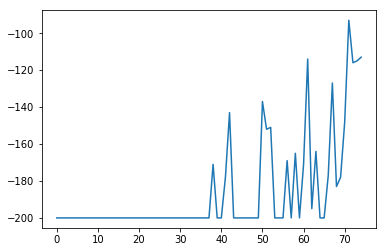

In [5]:
env = gym.make('MountainCar-v0')
env.seed(0)
env = gym.wrappers.Monitor(env, "./records", video_callable=lambda _:True)

agent = SARSALambdaAgent(env)  

episodes = 75
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

### Test

In [6]:
agent.epsilon = 0.
episodes = 100
episode_rewards = [play_sarsa(env, agent, train=False) for _ in range(episodes)]
print('average award = {} / {} = {}'.format(
        sum(episode_rewards), len(episode_rewards), np.mean(episode_rewards)))

average award = -10357.0 / 100 = -103.57


### Plot Policy

D:\Programs\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


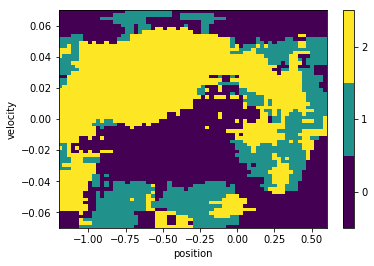

In [7]:
poses = np.linspace(env.unwrapped.min_position, env.unwrapped.max_position, 256)
vels = np.linspace(-env.unwrapped.max_speed, env.unwrapped.max_speed, 256)
positions, velocities = np.meshgrid(poses, vels)

@np.vectorize
def decide(position, velocity):
    return agent.decide((position, velocity))

action_values = decide(positions, velocities)

fig, ax = plt.subplots()
c = ax.pcolormesh(positions, velocities, action_values)
ax.set_xlabel('position')
ax.set_ylabel('velocity')
fig.colorbar(c, ax=ax, boundaries=[-.5, .5, 1.5, 2.5], ticks=[0, 1, 2])
fig.show();

### Save Agent

In [8]:
import pickle
with open('./resources/agent.pkl', 'wb') as file:
    pickle.dump(agent, file)

In [9]:
env.close()